In [ ]:
!pip install --upgrade opencv-python==4.2.0
!pip install --upgrade vcd==6.0
!pip install ffmpeg
!pip install ffmpeg-python

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.2.0 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)
ERROR: No matching distribution found for opencv-python==4.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=e7f889f7f1aef78ca5ada4265985486ac33b8021063e566f2c65436f40c37a85
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/DMD/Videos_BodyCam/gaze_on_road
! ls

/content/drive/.shortcut-targets-by-id/1J94HdD7kQ1V6WjLrQ8OrpjEXMBpOBC1d/DMD/Videos_BodyCam/gaze_on_road
looking_road  not_looking_road


In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from collections import Counter

# Paths to datasets
dataset_paths = {
    "actions": '/content/drive/My Drive/DMD/Videos_BodyCam/driver_actions',
    "gaze": '/content/drive/My Drive/DMD/Videos_BodyCam/gaze_on_road',
    "hands_using_wheel": '/content/drive/My Drive/DMD/Videos_BodyCam/hands_using_wheel',
}

# Initialize a dictionary to hold train and test splits for each dataset
dataset_splits = {}

# Process each dataset
for dataset_type, base_path in dataset_paths.items():
    data = []  # Hold (file_path, label) pairs
    labels = []  # Hold labels only for stratified splitting

    # Traverse folders and assign labels
    for label in os.listdir(base_path):
        folder_path = os.path.join(base_path, label)
        if os.path.isdir(folder_path):
            for video_file in os.listdir(folder_path):
                if video_file.endswith('.mp4'):  # Adjust if videos have a different format
                    file_path = os.path.join(folder_path, video_file)
                    data.append((file_path, label))
                    labels.append(label)

    # Ensure consistent shuffling
    random.seed(42)
    random.shuffle(data)

    # Extract file paths and labels separately
    file_paths = [item[0] for item in data]
    labels = [item[1] for item in data]

    # Stratified train-test split (80% train, 20% test)
    train_files, test_files, train_labels, test_labels = train_test_split(
        file_paths, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Save splits in the dataset_splits dictionary
    dataset_splits[dataset_type] = {
        "train": list(zip(train_files, train_labels)),
        "test": list(zip(test_files, test_labels)),
    }

    # Print dataset statistics
    print(f"{dataset_type.capitalize()} Dataset:")
    print(f"  Total: {len(data)} videos")
    print(f"  Training: {len(train_files)} videos ({Counter(train_labels)})")
    print(f"  Testing: {len(test_files)} videos ({Counter(test_labels)})\n")

# Optional: View a few samples from a dataset
print("Sample from Actions Train Set:", dataset_splits["actions"]["train"][:5])
print("Sample from Actions Test Set:", dataset_splits["actions"]["test"][:5])


Actions Dataset:
  Total: 10392 videos
  Training: 8313 videos (Counter({'safe_drive': 3164, 'phonecall_left': 1235, 'phonecall_right': 1149, 'reach_side': 685, 'texting_left': 444, 'texting_right': 442, 'hair_and_makeup': 388, 'radio': 363, 'drinking': 322, 'reach_backseat': 121}))
  Testing: 2079 videos (Counter({'safe_drive': 791, 'phonecall_left': 309, 'phonecall_right': 288, 'reach_side': 171, 'texting_left': 111, 'texting_right': 110, 'hair_and_makeup': 97, 'radio': 91, 'drinking': 81, 'reach_backseat': 30}))

Gaze Dataset:
  Total: 908 videos
  Training: 726 videos (Counter({'not_looking_road': 363, 'looking_road': 363}))
  Testing: 182 videos (Counter({'looking_road': 91, 'not_looking_road': 91}))

Hands_using_wheel Dataset:
  Total: 11928 videos
  Training: 9542 videos (Counter({'only_left': 4275, 'both': 3068, 'only_right': 1839, 'none': 360}))
  Testing: 2386 videos (Counter({'only_left': 1069, 'both': 767, 'only_right': 460, 'none': 90}))

Sample from Actions Train Set: [('

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import warnings


class DriverActionDataset(Dataset):
    def __init__(self, data, transform=None, clip_len=30):
        """
        Args:
            data: List of tuples (video_path, label) for each video.
            transform: Optional transformations to apply to each frame.
            clip_len: Fixed number of frames for each video clip.
        """
        assert isinstance(clip_len, int) and clip_len > 0, "clip_len must be a positive integer."
        self.data = data
        self.transform = transform
        self.clip_len = clip_len  # Set a fixed length for all clips

        # Create a mapping from label names to numeric indices
        self.label_map = {label: idx for idx, label in enumerate(set([label for _, label in data]))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the video path and label
        video_path, label = self.data[idx]

        # Initialize video capture
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            warnings.warn(f"Cannot open video file: {video_path}. Using zero frames.")
            return torch.zeros((3, self.clip_len, 224, 224)), self.label_map[label]

        frames = []
        frame_count = 0  # Counter to track frame position

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Grab every 3rd frame
            if frame_count % 3 == 0:
                # Resize the frame
                frame = cv2.resize(frame, (224, 224))

                # Apply transformations
                if self.transform:
                    frame = self.transform(frame)

                # Convert to tensor and normalize
                if isinstance(frame, np.ndarray):
                    frame_tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
                else:
                    frame_tensor = frame  # Assume transform already converts to tensor

                frames.append(frame_tensor)

            frame_count += 1

        cap.release()

        # Handle empty or corrupted videos
        if len(frames) == 0:
            warnings.warn(f"Empty or unreadable video at {video_path}. Using zero frames.")
            frames = [torch.zeros((3, 224, 224))] * self.clip_len

        # Truncate or pad frames
        if len(frames) > self.clip_len:
            frames = frames[:self.clip_len]
        elif len(frames) < self.clip_len:
            frames.extend([frames[-1]] * (self.clip_len - len(frames)))

        # Stack frames into a single tensor
        video_tensor = torch.stack(frames).permute(1, 0, 2, 3)  # Shape: (Channels, clip_len, Height, Width)

        # Convert label to index
        label_idx = self.label_map[label]

        return video_tensor, label_idx


In [ ]:
# Define transformations
from torchvision.transforms import Compose, Normalize, ToTensor

# Transform is currently set to None
# Update this with preprocessing as needed
transform = None

# Clip length for videos
clip_len = 20

# Initialize the datasets
actions_train_dataset = DriverActionDataset(
    data=dataset_splits["actions"]["train"],
    transform=transform,
    clip_len=clip_len
)

actions_test_dataset = DriverActionDataset(
    data=dataset_splits["actions"]["test"],
    transform=transform,
    clip_len=clip_len
)

gaze_train_dataset = DriverActionDataset(
    data=dataset_splits["gaze"]["train"],
    transform=transform,
    clip_len=clip_len
)

gaze_test_dataset = DriverActionDataset(
    data=dataset_splits["gaze"]["test"],
    transform=transform,
    clip_len=clip_len
)

hands_train_dataset = DriverActionDataset(
    data=dataset_splits["hands_using_wheel"]["train"],
    transform=transform,
    clip_len=clip_len
)

hands_test_dataset = DriverActionDataset(
    data=dataset_splits["hands_using_wheel"]["test"],
    transform=transform,
    clip_len=clip_len
)

# Get the list of all label names from the actions train dataset
actions_label_names = list(actions_train_dataset.label_map.keys())
gaze_label_names = list(gaze_train_dataset.label_map.keys())
hands_label_names = list(hands_train_dataset.label_map.keys())

# Output label names
print("All actions label names:", actions_label_names)
print("All gaze label names:", gaze_label_names)
print("All hands label names:", hands_label_names)
print("============================================================================")
# Number of samples in each dataset
print("Number of samples in Actions Training Dataset:", len(actions_train_dataset))
print("Number of samples in Actions Testing Dataset:", len(actions_test_dataset))
print("============================================================================")
print("Number of samples in Gaze Training Dataset:", len(gaze_train_dataset))
print("Number of samples in Gaze Testing Dataset:", len(gaze_test_dataset))
print("============================================================================")
print("Number of samples in Hand on wheel Training Dataset:", len(hands_train_dataset))
print("Number of samples in Hand on wheel Testing Dataset:", len(hands_test_dataset))


All actions label names: ['hair_and_makeup', 'texting_left', 'phonecall_left', 'reach_side', 'radio', 'phonecall_right', 'drinking', 'texting_right', 'safe_drive', 'reach_backseat']
All gaze label names: ['not_looking_road', 'looking_road']
All hands label names: ['only_left', 'both', 'only_right', 'none']
Number of samples in Actions Training Dataset: 8313
Number of samples in Actions Testing Dataset: 2079
Number of samples in Gaze Training Dataset: 726
Number of samples in Gaze Testing Dataset: 182
Number of samples in Hand on wheel Training Dataset: 9542
Number of samples in Hand on wheel Testing Dataset: 2386


In [ ]:
from collections import Counter

# Assuming labels are the second element in each sample
all_labels = [gaze_test_dataset[i][1] for i in range(len(gaze_test_dataset))]
label_counts = Counter(all_labels)
num_classes = len(label_counts)

print(f"Number of classes: {num_classes}")
print(f"Class distribution: {label_counts}")

# #['only_right', 'both', 'none', 'only_left'] === Testing: 2386 videos (Counter({'only_left': 1069, 'both': 767, 'only_right': 460, 'none': 90}))
# Total: 10392 videos
#   Training: 8313 videos (Counter({'safe_drive': 3164, 'phonecall_left': 1235, 'phonecall_right': 1149, 'reach_side': 685, 'texting_left': 444, 'texting_right': 442, 'hair_and_makeup': 388, 'radio': 363, 'drinking': 322, 'reach_backseat': 121}))
#   Testing: 2079 videos (Counter({'safe_drive': 791, 'phonecall_left': 309, 'phonecall_right': 288, 'reach_side': 171, 'texting_left': 111, 'texting_right': 110, 'hair_and_makeup': 97, 'radio': 91, 'drinking': 81, 'reach_backseat': 30}))
# ['safe_drive', 'drinking', 'phonecall_left', 'radio', 'texting_right', 'hair_and_makeup', 'phonecall_right', 'reach_backseat', 'texting_left', 'reach_side']

KeyboardInterrupt: 

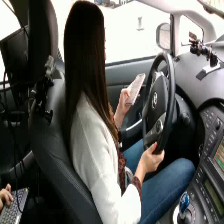

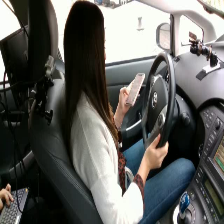

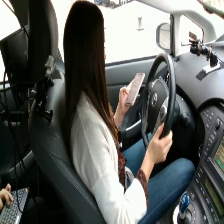

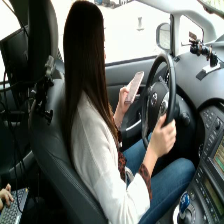

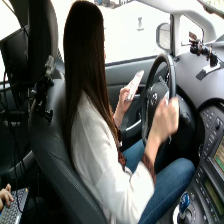

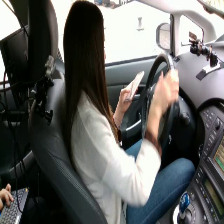

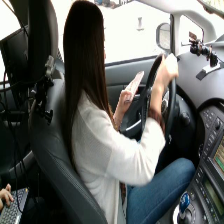

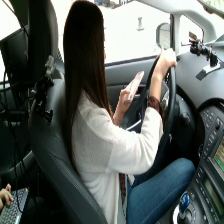

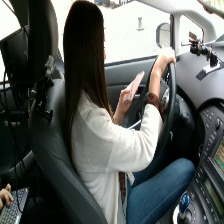

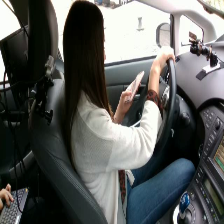

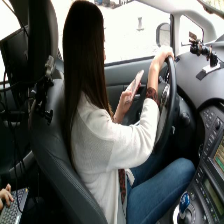

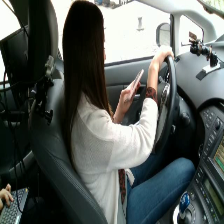

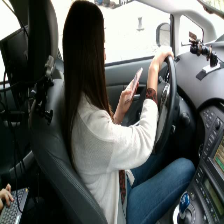

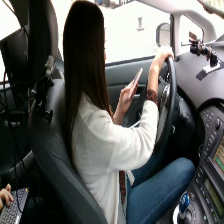

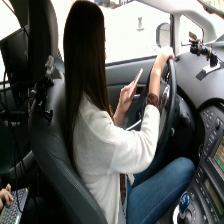

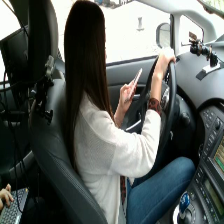

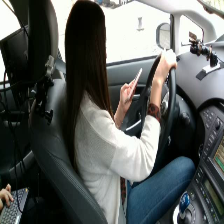

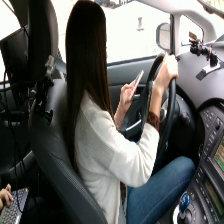

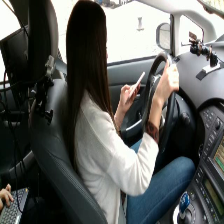

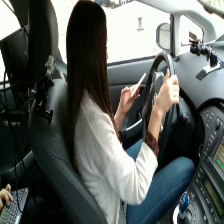

In [ ]:
# Fetch the first sample from the dataset
train_dataset = gaze_train_dataset
video_tensor, label_idx = train_dataset[499]

# print("Video Tensor Shape:", video_tensor.shape)  # Expected: (Channels, clip_len, Height, Width)
# print("Label Index:", label_idx)


# label_name = [name for name, idx in train_dataset.label_map.items() if idx == label_idx][0]
# print("Label Name:", label_name)

from google.colab.patches import cv2_imshow
import numpy as np

# Convert video tensor to NumPy for easier display
video_np = video_tensor.permute(1, 2, 3, 0).numpy()  # Convert to (Num Frames, Height, Width, Channels)
# video_np = video_tensor.permute(0, 2, 3, 1).numpy()

# Display each frame
for i, frame in enumerate(video_np):
    frame = (frame * 255).astype(np.uint8)  # Convert back to uint8 if needed (normalize to 0-255 if originally scaled)
    # stacked_frames = np.vstack(frame)  # Stack frames vertically for display
    cv2_imshow(frame)



In [ ]:
!pip install pytorchvideo
!pip install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 67.0 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=68385a97f8f0a3f6f69457a1bb4e6d437a7d87a02e22beeae3ebee1468812647
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=48939037a0a0085feb7bf9e6d3bb0d9be1934a41bd93a48d82a9cdab73ece8d5
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel 

In [ ]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming `dataset` is your initialized dataset object

actions_num_classes = len(actions_train_dataset.label_map)  # Define the number of classes based on the dataset
gaze_num_classes = len(gaze_train_dataset.label_map)  # Define the number of classes based on the dataset
hands_num_classes = len(hands_train_dataset.label_map)  # Define the number of classes based on the dataset
actions_num_classes,gaze_num_classes,hands_num_classes

(10, 2, 4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models.video as models
import torch
from pytorchvideo.models import resnet
from transformers import get_linear_schedule_with_warmup
import json

In [ ]:
from torch.utils.data import DataLoader

# Define batch size and number of epochs
batch_size = 8
num_epochs = 10

# Create DataLoader for training
actions_train_dataloader = DataLoader(actions_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
actions_test_dataloader = DataLoader(actions_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

gaze_train_dataloader = DataLoader(gaze_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
gaze_test_dataloader = DataLoader(gaze_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

hands_train_dataloader = DataLoader(hands_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
hands_test_dataloader = DataLoader(hands_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

actions_train_dataloader, actions_test_dataloader,gaze_train_dataloader, gaze_test_dataloader,hands_train_dataloader, hands_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x786c36c02e00>,
 <torch.utils.data.dataloader.DataLoader at 0x786c36c02c20>)

In [ ]:
print(len(actions_train_dataloader), len(actions_test_dataloader))
print(len(gaze_train_dataloader), len(gaze_test_dataloader))
print(len(hands_train_dataloader), len(hands_test_dataloader))

1040 260
91 23
1193 299


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm.auto import tqdm


def calculate_metrics(predictions, labels, probabilities, num_classes):
    """
    Calculate classification metrics, including per-class and overall ROC AUC, and confusion matrix.

    Args:
        predictions (array): Predicted class indices.
        labels (array): True class labels.
        probabilities (array): Predicted probabilities for each class.
        num_classes (int): Number of classes in the classification task.

    Returns:
        metrics (dict): Dictionary containing accuracy, precision, recall, F1-score,
                        per-class ROC AUC, overall ROC AUC, and confusion matrix.
    """
    # Accuracy, precision, recall, F1 score
    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(labels, predictions, average='macro')

    # Overall ROC AUC (multi-class OvR)
    try:
        overall_roc_auc = roc_auc_score(labels, probabilities[:,1]) if num_classes == 2 else roc_auc_score(labels, probabilities, multi_class='ovr', average='macro')
    except ValueError:
        overall_roc_auc = float('nan')  # Handle cases where ROC AUC cannot be computed

    # Per-class ROC AUC
    per_class_roc_auc = {}
    for class_idx in range(num_classes):
        try:
            per_class_roc_auc[class_idx] = roc_auc_score(
                (labels == class_idx).astype(int), probabilities[:, class_idx]
            )
        except ValueError:
            per_class_roc_auc[class_idx] = float('nan')  # Handle cases where a class is missing

    # Confusion Matrix
    conf_matrix = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'overall_roc_auc': overall_roc_auc,
        'per_class_roc_auc': per_class_roc_auc,
        'confusion_matrix': conf_matrix
    }


def train_step(model: Module, dataloader: DataLoader, loss_fn: Module, optimizer, scheduler, device, num_classes):
    """
    Performs one training step and calculates metrics.

    Args:
        model (Module): The PyTorch model.
        dataloader (DataLoader): DataLoader for the training dataset.
        loss_fn (Module): Loss function.
        optimizer: Optimizer for the model.
        scheduler: Learning rate scheduler.
        device: The device (CPU or GPU).
        num_classes (int): Number of classes in the classification task.

    Returns:
        tuple: Mean loss and metrics dictionary.
    """
    model.train()
    losses = []
    all_predictions = []
    all_labels = []
    all_probabilities = []

    for inputs, labels in tqdm(dataloader, desc="Training Step"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)  # Outputs are logits
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        # Collect predictions, probabilities, and labels
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy()
        predicted = np.argmax(probabilities, axis=1)

        all_predictions.extend(predicted)
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities)

    # Metrics calculation
    metrics = calculate_metrics(
        predictions=np.array(all_predictions),
        labels=np.array(all_labels),
        probabilities=np.array(all_probabilities),
        num_classes=num_classes
    )

    return np.mean(losses), metrics


def test_step(model: Module, dataloader: DataLoader, loss_fn: Module, device, num_classes):
    """
    Performs one evaluation step and calculates metrics.

    Args:
        model (Module): The PyTorch model.
        dataloader (DataLoader): DataLoader for the validation or test dataset.
        loss_fn (Module): Loss function.
        device: The device (CPU or GPU).
        num_classes (int): Number of classes in the classification task.

    Returns:
        tuple: Mean loss and metrics dictionary.
    """
    model.eval()
    losses = []
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing Step"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)  # Outputs are logits
            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # Collect predictions, probabilities, and labels
            probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            predicted = np.argmax(probabilities, axis=1)

            all_predictions.extend(predicted)
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities)

    # Metrics calculation
    metrics = calculate_metrics(
        predictions=np.array(all_predictions),
        labels=np.array(all_labels),
        probabilities=np.array(all_probabilities),
        num_classes=num_classes
    )

    # Debugging outputs
    print("\nDebugging Information:")
    print("Ground Truth Distribution:", np.unique(all_labels, return_counts=True))
    print("Prediction Distribution:", np.unique(all_predictions, return_counts=True))
    print("Confusion Matrix Totals:", metrics['confusion_matrix'].sum(axis=1))
    print("Total Samples Processed:", metrics['confusion_matrix'].sum())

    return np.mean(losses), metrics

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min', verbose=False):
        """
        Early stops the training if validation metric does not improve after a given patience.

        Args:
            patience (int): How many epochs to wait for improvement before stopping.
            min_delta (float): Minimum change in the monitored metric to qualify as improvement.
            mode (str): Whether to monitor 'min' or 'max' (e.g., minimize loss or maximize accuracy).
            verbose (bool): Whether to print a message when stopping early.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        else:
            improvement = (current_score - self.best_score) if self.mode == 'max' else (self.best_score - current_score)
            if improvement > self.min_delta:
                self.best_score = current_score
                self.counter = 0
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement. Patience counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True


import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plots a confusion matrix using matplotlib and seaborn.

    Args:
        conf_matrix (array): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, epochs, device, num_classes, class_names,patience):
    """
    Trains the model and evaluates on validation set at each epoch.

    Args:
        model (Module): The PyTorch model.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        val_dataloader (DataLoader): DataLoader for the validation dataset.
        optimizer: Optimizer for the model.
        loss_fn (Module): Loss function.
        scheduler: Learning rate scheduler.
        epochs (int): Number of epochs to train.
        device: The device (CPU or GPU).
        num_classes (int): Number of classes in the classification task.
        class_names (list): List of class names.

    Returns:
        dict: Training and validation metrics history.
    """
    early_stopping = EarlyStopping(patience=patience, mode='min', verbose=True)
    history = {
        "train_loss": [], "val_loss": [],
        "train_metrics": [], "val_metrics": []
    }

    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_metrics = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            num_classes=num_classes
        )

        # Validation step
        val_loss, val_metrics = test_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device,
            num_classes=num_classes
        )

        # Store metrics in history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_metrics"].append(train_metrics)
        history["val_metrics"].append(val_metrics)

        # Print metrics for the epoch
        print(f"Epoch: {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_metrics['accuracy']:.2f}% | Precision: {train_metrics['precision']:.4f} | Recall: {train_metrics['recall']:.4f} | F1 Score: {train_metrics['f1']:.4f} | ROC AUC: {train_metrics['overall_roc_auc']:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_metrics['accuracy']:.2f}% | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | F1 Score: {val_metrics['f1']:.4f} | ROC AUC: {val_metrics['overall_roc_auc']:.4f}")

        # Print per-class ROC AUC for validation
        print("\nValidation ROC AUC Per Class:")
        for class_idx, auc_score in val_metrics['per_class_roc_auc'].items():
            print(f"Class {class_names[class_idx]}: {auc_score:.4f}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Training halted.")
            break

    # After training, plot confusion matrix for validation
    final_val_metrics = history["val_metrics"][-1]
    conf_matrix = final_val_metrics['confusion_matrix']
    print("\nConfusion Matrix:")
    plot_confusion_matrix(conf_matrix, class_names)

    return model, history


In [ ]:
def build_resnet_model(num_classes, device, dtype):
  # Initialize the model with explicit device and dtype
    resnet_model = resnet.create_resnet(
    input_channel=3,
    model_depth=50,
    model_num_class=num_classes
    ).to(device=device, dtype=dtype)
    return resnet_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

actions_resnet_model = build_resnet_model(actions_num_classes, device, dtype)
gaze_resnet_model = build_resnet_model(gaze_num_classes, device, dtype)
hands_resnet_model = build_resnet_model(hands_num_classes, device, dtype)
# actions_train_dataloader, actions_test_dataloader,gaze_train_dataloader, gaze_test_dataloader,hands_train_dataloader, hands_test_dataloader

In [ ]:
from torchsummary import summary

# Specify an example input shape based on your data
# For a 3D CNN, an example input might be (Channels, Frames, Height, Width)
input_shape = (3, 30, 224, 224)  # Adjust to match your input data shape

# Display the model summary
summary(hands_resnet_model, input_size=input_shape, device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 30, 112, 112]          28,224
       BatchNorm3d-2     [-1, 64, 30, 112, 112]             128
              ReLU-3     [-1, 64, 30, 112, 112]               0
         MaxPool3d-4       [-1, 64, 30, 56, 56]               0
   ResNetBasicStem-5       [-1, 64, 30, 56, 56]               0
            Conv3d-6      [-1, 256, 30, 56, 56]          16,384
       BatchNorm3d-7      [-1, 256, 30, 56, 56]             512
            Conv3d-8       [-1, 64, 30, 56, 56]           4,096
       BatchNorm3d-9       [-1, 64, 30, 56, 56]             128
             ReLU-10       [-1, 64, 30, 56, 56]               0
           Conv3d-11       [-1, 64, 30, 56, 56]          36,864
      BatchNorm3d-12       [-1, 64, 30, 56, 56]             128
             ReLU-13       [-1, 64, 30, 56, 56]               0
           Conv3d-14      [-1, 256, 30,

In [ ]:
# Set random seeds

def train_resnet(resnet_model,train_dataloader,test_dataloader,num_classes,label_names):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  np.random.seed(42)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
  epochs = 10
  total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
  patience = 2

# Start the timer
  from timeit import default_timer as timer
  start_time = timer()

# Call the train function with the additional arguments
  resnet_model, history = train(
      model=resnet_model,
      train_dataloader=train_dataloader,
      val_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=criterion,
      scheduler=scheduler,
      epochs=epochs,
      device=device,
      num_classes=num_classes,
      class_names=label_names,
      patience=patience
  )

# Calculate the elapsed time
  end_time = timer()
  elapsed_time = end_time - start_time
  print(f"Elapsed time: {elapsed_time:.2f} seconds")
  return resnet_model, history


In [ ]:
resnet_model, actions_history= train_resnet(actions_resnet_model,actions_train_dataloader,actions_test_dataloader,actions_num_classes,actions_label_names)

In [ ]:
MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/resnet_model.pth'
torch.save(resnet_model.state_dict(), MODEL_SAVE_PATH)

import json
for key, value in actions_history.items():
    print(f"Key: {key}, Example Element: {value[0] if len(value) > 0 else 'Empty'}, Type: {type(value[0]) if len(value) > 0 else 'Empty'}")


def make_serializable(data):
    """
    Recursively convert data to JSON-serializable types.
    """
    if isinstance(data, dict):
        return {k: make_serializable(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [make_serializable(v) for v in data]
    elif isinstance(data, (np.ndarray, torch.Tensor)):
        return data.tolist()  # Convert arrays/tensors to lists
    elif isinstance(data, (float, int, str, bool, type(None))):
        return data  # Already serializable
    else:
        return str(data)  # Convert unknown types to strings

serializable_history = make_serializable(actions_history)

history_file = "/content/drive/My Drive/DMD/models/action_3d_model_history.json"

with open(history_file, "w") as f:
    json.dump(serializable_history, f)

print(f"Training history saved to {history_file}")


In [ ]:
gaze_resnet_model, gaze_history = train_resnet(gaze_resnet_model,gaze_train_dataloader,gaze_test_dataloader,gaze_num_classes,gaze_label_names)

In [ ]:
GAZE_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/gaze_resnet_model.pth'

torch.save(gaze_resnet_model.state_dict(), GAZE_MODEL_SAVE_PATH)


import json
for key, value in gaze_history.items():
    print(f"Key: {key}, Example Element: {value[0] if len(value) > 0 else 'Empty'}, Type: {type(value[0]) if len(value) > 0 else 'Empty'}")


def make_serializable(data):
    """
    Recursively convert data to JSON-serializable types.
    """
    if isinstance(data, dict):
        return {k: make_serializable(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [make_serializable(v) for v in data]
    elif isinstance(data, (np.ndarray, torch.Tensor)):
        return data.tolist()  # Convert arrays/tensors to lists
    elif isinstance(data, (float, int, str, bool, type(None))):
        return data  # Already serializable
    else:
        return str(data)  # Convert unknown types to strings

serializable_history = make_serializable(gaze_history)

history_file = "/content/drive/My Drive/DMD/models/gaze_3d_model_history.json"

with open(history_file, "w") as f:
    json.dump(serializable_history, f)

print(f"Training history saved to {history_file}")


  0%|          | 0/10 [00:00<?, ?it/s]

Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  49,  184,  638, 1515]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 1/10
Train Loss: 0.8176 | Train Accuracy: 67.08% | Precision: 0.5211 | Recall: 0.4874 | F1 Score: 0.4871 | ROC AUC: 0.7957
Val Loss: 0.8499 | Val Accuracy: 75.57% | Precision: 0.6654 | Recall: 0.5418 | F1 Score: 0.5621 | ROC AUC: 0.9254

Validation ROC AUC Per Class:
Class none: 0.7922
Class only_right: 0.9785
Class both: 0.9510
Class only_left: 0.9800


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  14,  447,  809, 1116]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 2/10
Train Loss: 0.3353 | Train Accuracy: 88.93% | Precision: 0.8091 | Recall: 0.7307 | F1 Score: 0.7451 | ROC AUC: 0.9415
Val Loss: 0.2238 | Val Accuracy: 93.46% | Precision: 0.9531 | Recall: 0.7581 | F1 Score: 0.7781 | ROC AUC: 0.9705

Validation ROC AUC Per Class:
Class none: 0.8994
Class only_right: 0.9965
Class both: 0.9931
Class only_left: 0.9930


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0bb4a9ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  88,  437,  771, 1090]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 3/10
Train Loss: 0.1945 | Train Accuracy: 93.94% | Precision: 0.8841 | Recall: 0.8191 | F1 Score: 0.8401 | ROC AUC: 0.9715
Val Loss: 0.1826 | Val Accuracy: 94.17% | Precision: 0.8652 | Recall: 0.8557 | F1 Score: 0.8603 | ROC AUC: 0.9839

Validation ROC AUC Per Class:
Class none: 0.9482
Class only_right: 0.9974
Class both: 0.9950
Class only_left: 0.9951


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0bb4a9ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  95,  460,  757, 1074]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 4/10
Train Loss: 0.1465 | Train Accuracy: 95.24% | Precision: 0.9032 | Recall: 0.8475 | F1 Score: 0.8677 | ROC AUC: 0.9816
Val Loss: 0.1506 | Val Accuracy: 95.14% | Precision: 0.8699 | Recall: 0.8761 | F1 Score: 0.8729 | ROC AUC: 0.9838

Validation ROC AUC Per Class:
Class none: 0.9452
Class only_right: 0.9968
Class both: 0.9963
Class only_left: 0.9968


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  67,  470,  772, 1077]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 5/10
Train Loss: 0.1106 | Train Accuracy: 96.49% | Precision: 0.9303 | Recall: 0.8830 | F1 Score: 0.9022 | ROC AUC: 0.9880
Val Loss: 0.1167 | Val Accuracy: 97.32% | Precision: 0.9607 | Recall: 0.9103 | F1 Score: 0.9311 | ROC AUC: 0.9865

Validation ROC AUC Per Class:
Class none: 0.9539
Class only_right: 0.9982
Class both: 0.9970
Class only_left: 0.9969


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  86,  465,  776, 1059]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 6/10
Train Loss: 0.0771 | Train Accuracy: 97.47% | Precision: 0.9434 | Recall: 0.9157 | F1 Score: 0.9281 | ROC AUC: 0.9946
Val Loss: 0.1111 | Val Accuracy: 96.73% | Precision: 0.9178 | Recall: 0.9126 | F1 Score: 0.9151 | ROC AUC: 0.9900

Validation ROC AUC Per Class:
Class none: 0.9668
Class only_right: 0.9987
Class both: 0.9975
Class only_left: 0.9972


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  62,  453,  809, 1062]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 7/10
Train Loss: 0.0572 | Train Accuracy: 98.11% | Precision: 0.9578 | Recall: 0.9355 | F1 Score: 0.9458 | ROC AUC: 0.9967
Val Loss: 0.1326 | Val Accuracy: 96.61% | Precision: 0.9544 | Recall: 0.8905 | F1 Score: 0.9156 | ROC AUC: 0.9893

Validation ROC AUC Per Class:
Class none: 0.9644
Class only_right: 0.9981
Class both: 0.9977
Class only_left: 0.9968
No improvement. Patience counter: 1/2


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  84,  459,  779, 1064]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 8/10
Train Loss: 0.0404 | Train Accuracy: 98.71% | Precision: 0.9694 | Recall: 0.9500 | F1 Score: 0.9591 | ROC AUC: 0.9982
Val Loss: 0.0951 | Val Accuracy: 97.82% | Precision: 0.9414 | Recall: 0.9298 | F1 Score: 0.9354 | ROC AUC: 0.9925

Validation ROC AUC Per Class:
Class none: 0.9754
Class only_right: 0.9989
Class both: 0.9981
Class only_left: 0.9977


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  78,  464,  774, 1070]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 9/10
Train Loss: 0.0219 | Train Accuracy: 99.35% | Precision: 0.9822 | Recall: 0.9733 | F1 Score: 0.9776 | ROC AUC: 0.9991
Val Loss: 0.0903 | Val Accuracy: 97.86% | Precision: 0.9473 | Recall: 0.9237 | F1 Score: 0.9345 | ROC AUC: 0.9929

Validation ROC AUC Per Class:
Class none: 0.9760
Class only_right: 0.9986
Class both: 0.9985
Class only_left: 0.9986


Training Step:   0%|          | 0/1193 [00:00<?, ?it/s]

Testing Step:   0%|          | 0/299 [00:00<?, ?it/s]


Debugging Information:
Ground Truth Distribution: (array([0, 1, 2, 3]), array([  90,  460,  767, 1069]))
Prediction Distribution: (array([0, 1, 2, 3]), array([  83,  466,  776, 1061]))
Confusion Matrix Totals: [  90  460  767 1069]
Total Samples Processed: 2386
Epoch: 10/10
Train Loss: 0.0114 | Train Accuracy: 99.66% | Precision: 0.9908 | Recall: 0.9842 | F1 Score: 0.9875 | ROC AUC: 0.9999
Val Loss: 0.0882 | Val Accuracy: 97.95% | Precision: 0.9472 | Recall: 0.9349 | F1 Score: 0.9407 | ROC AUC: 0.9937

Validation ROC AUC Per Class:
Class none: 0.9791
Class only_right: 0.9984
Class both: 0.9985
Class only_left: 0.9988

Confusion Matrix:


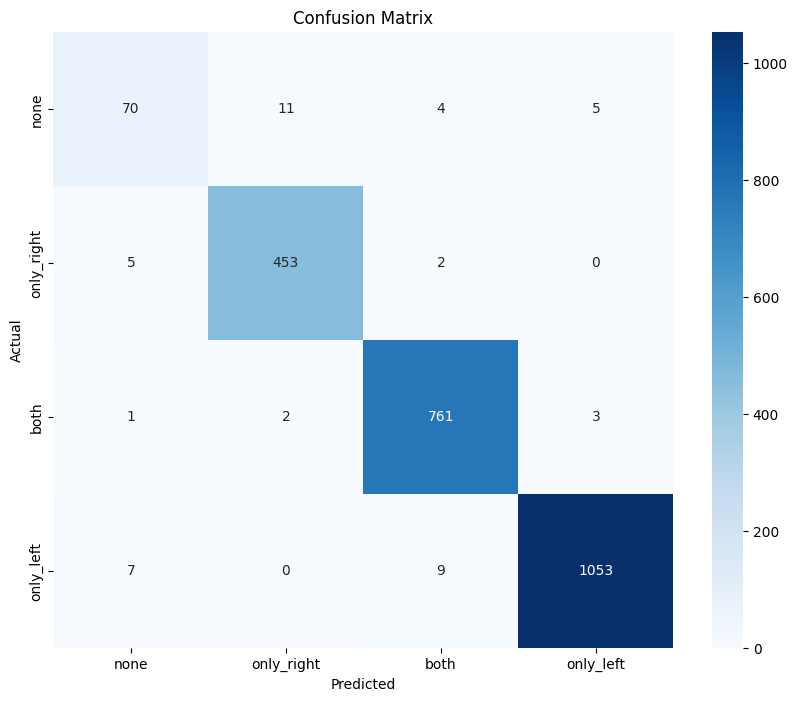

Elapsed time: 15541.26 seconds


In [ ]:
hands_resnet_model, hands_history= train_resnet(hands_resnet_model,hands_train_dataloader,hands_test_dataloader,hands_num_classes,hands_label_names)

In [ ]:
HANDS_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/hands_resnet_model.pth'
torch.save(hands_resnet_model.state_dict(), HANDS_MODEL_SAVE_PATH)


import json
for key, value in hands_history.items():
    print(f"Key: {key}, Example Element: {value[0] if len(value) > 0 else 'Empty'}, Type: {type(value[0]) if len(value) > 0 else 'Empty'}")


def make_serializable(data):
    """
    Recursively convert data to JSON-serializable types.
    """
    if isinstance(data, dict):
        return {k: make_serializable(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [make_serializable(v) for v in data]
    elif isinstance(data, (np.ndarray, torch.Tensor)):
        return data.tolist()  # Convert arrays/tensors to lists
    elif isinstance(data, (float, int, str, bool, type(None))):
        return data  # Already serializable
    else:
        return str(data)  # Convert unknown types to strings

serializable_history = make_serializable(hands_history)

history_file = "/content/drive/My Drive/DMD/models/hands_3d_model_history.json"

with open(history_file, "w") as f:
    json.dump(serializable_history, f)

print(f"Training history saved to {history_file}")


Key: train_loss, Example Element: 0.81761973158262, Type: <class 'numpy.float64'>
Key: val_loss, Example Element: 0.8499442575449578, Type: <class 'numpy.float64'>
Key: train_metrics, Example Element: {'accuracy': 67.08237266820373, 'precision': 0.5210900534262948, 'recall': 0.4873714062020809, 'f1': 0.4870616939315876, 'overall_roc_auc': 0.7956622839532657, 'per_class_roc_auc': {0: 0.6271936034269949, 1: 0.8504929507419163, 2: 0.8402761582887562, 3: 0.864686423355395}, 'confusion_matrix': array([[   1,   59,   88,  212],
       [   0,  877,  425,  537],
       [   4,  270, 1933,  861],
       [   4,  206,  475, 3590]])}, Type: <class 'dict'>
Key: val_metrics, Example Element: {'accuracy': 75.56580050293378, 'precision': 0.665351810056323, 'recall': 0.5418306338427761, 'f1': 0.5621007137191707, 'overall_roc_auc': 0.9254142739053745, 'per_class_roc_auc': {0: 0.7921747967479674, 1: 0.9784843559528648, 2: 0.9509684942417012, 3: 0.9800294486789647}, 'confusion_matrix': array([[   5,    1, 

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
def plot_loss_curves(history):
    train_loss = history["train_loss"]
    val_loss = history["val_loss"]

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label="Training Loss", marker='o')
    plt.plot(val_loss, label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid()
    plt.show()

# plot_loss_curves(hands_history)
# Plot accuracy curves
def plot_accuracy_curves(history):
    train_accuracy = [metrics["accuracy"] for metrics in history["train_metrics"]]
    val_accuracy = [metrics["accuracy"] for metrics in history["val_metrics"]]

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, label="Training Accuracy", marker='o')
    plt.plot(val_accuracy, label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.grid()
    plt.show()

# plot_accuracy_curves(hands_history)
# Plot ROC AUC curves
def plot_roc_auc(history, label_names):
    train_roc_auc = [metrics["overall_roc_auc"] for metrics in history["train_metrics"]]
    val_roc_auc = [metrics["overall_roc_auc"] for metrics in history["val_metrics"]]

    plt.figure(figsize=(10, 6))
    plt.plot(train_roc_auc, label="Training ROC AUC", marker='o')
    plt.plot(val_roc_auc, label="Validation ROC AUC", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("ROC AUC")
    plt.title("ROC AUC Curves")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
# plot_roc_auc(hands_history, hands_label_names)
# Plot per-class ROC AUC
def plot_per_class_roc_auc(history, label_names, epoch=-1):
    # Get metrics for the desired epoch
    val_metrics = history["val_metrics"][epoch]
    per_class_roc_auc = val_metrics["per_class_roc_auc"]

    # Extract class names and their ROC AUCs
    class_names = label_names
    roc_auc_values = [per_class_roc_auc[class_idx] for class_idx in range(len(class_names))]

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, roc_auc_values, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("ROC AUC")
    plt.title(f"Per-Class ROC AUC (Epoch {epoch+1})")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

# Example usage
# plot_per_class_roc_auc(hands_history, hands_label_names)
# Combine all plots in one function
def plot_training_summary(history, label_names):
    plot_loss_curves(history)
    plot_accuracy_curves(history)
    plot_roc_auc(history, label_names)
    plot_per_class_roc_auc(history, label_names)

# Example usage



In [ ]:
plot_training_summary(actions_history, actions_label_names)

In [ ]:
plot_training_summary(gaze_history, gaze_label_names)

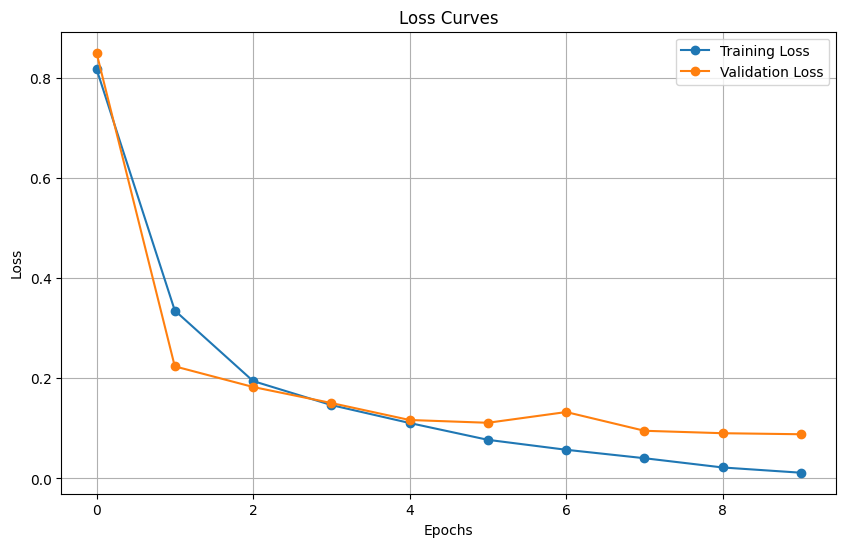

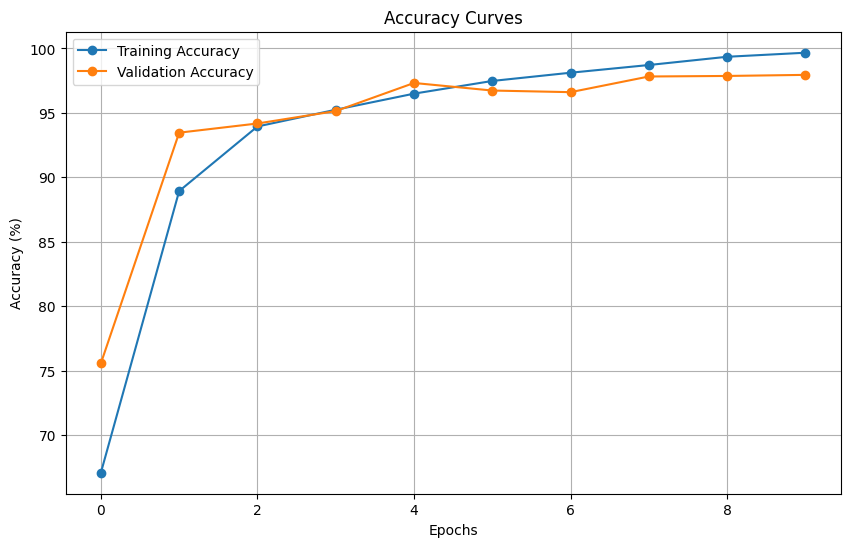

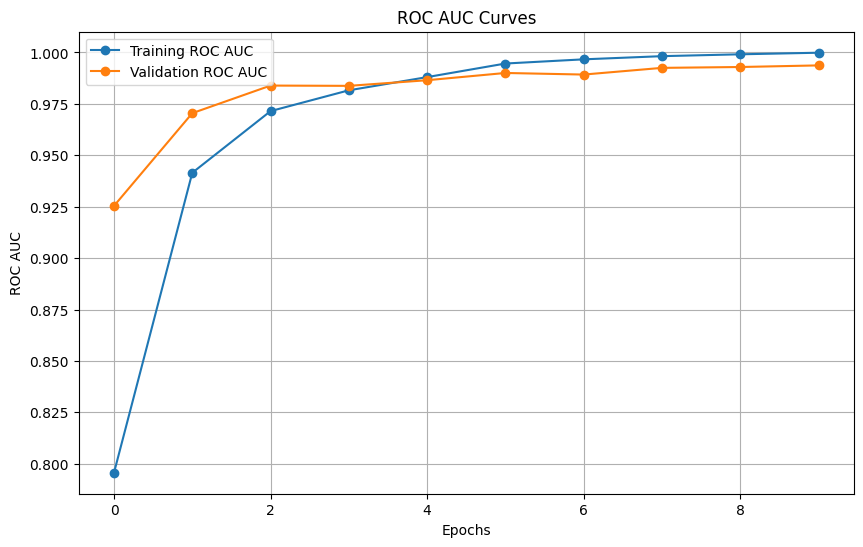

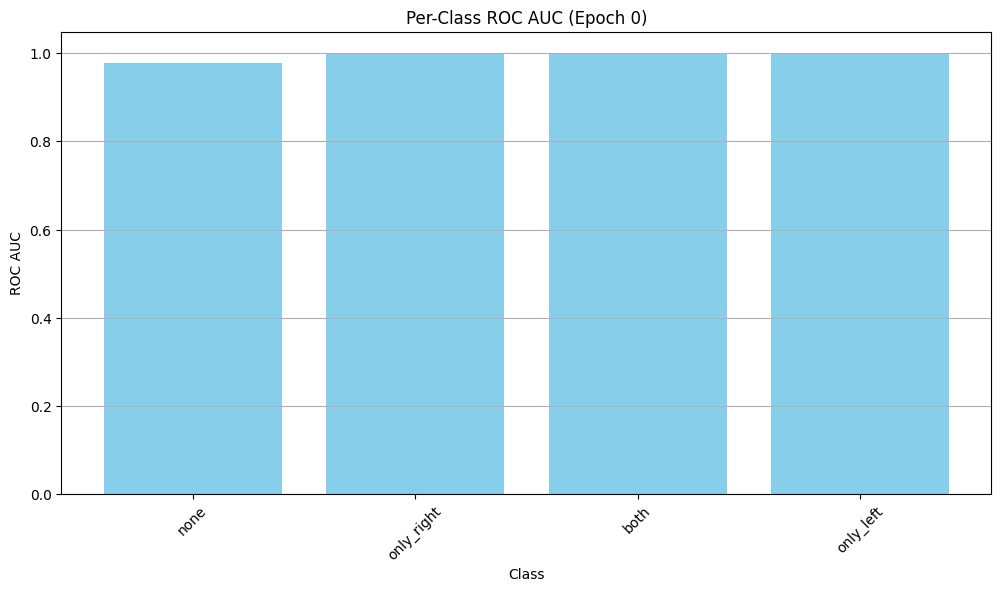

In [ ]:
plot_training_summary(hands_history, hands_label_names)

#Score-Based Evaluation method

In [ ]:
# Danger scores for actions
actions_danger_scores = {
    "safe_drive": 0.0,
    "phonecall_left": 0.7,
    "phonecall_right": 0.7,
    "reach_side": 0.5,
    "texting_left": 0.8,
    "texting_right": 0.8,
    "hair_and_makeup": 0.8,
    "radio": 0.4,
    "drinking": 0.6,
    "reach_backseat": 1.0,
}

# Danger scores for gaze
gaze_danger_scores = {
    "looking_road": 0.0,
    "not_looking_road": 1.0,
}

# Danger scores for hands
hands_danger_scores = {
    "both": 0.0,
    "only_left": 0.4,
    "only_right": 0.4,
    "none": 1.0,
}


In [ ]:
# Danger scores for actions
actions_danger_scores = {
    "safe_drive": 0.0,
    "phonecall_left": 1.0,
    "phonecall_right": 1.0,
    "reach_side": 1.0,
    "texting_left": 1.0,
    "texting_right": 1.0,
    "hair_and_makeup":1.0,
    "radio": 1.0,
    "drinking": 1.0,
    "reach_backseat": 1.0,
}

# Danger scores for gaze
gaze_danger_scores = {
    "looking_road": 0.0,
    "not_looking_road": 1.0,
}

# Danger scores for hands
hands_danger_scores = {
    "both": 0.0,
    "only_left": 0.5,
    "only_right": 0.5,
    "none": 1.0,
}


In [ ]:
GAZE_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/gaze_resnet_model.pth'
HANDS_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/hands_resnet_model.pth'
MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/resnet_model.pth'

In [ ]:
# HANDS_MODEL_SAVE_PATH = '/content/drive/My Drive/DMD/models/hands_resnet_model.pth'
# torch.save(gaze_resnet_model.state_dict(), HANDS_MODEL_SAVE_PATH)

In [ ]:
# Load the hands model
hands_resnet_model.load_state_dict(torch.load(HANDS_MODEL_SAVE_PATH))

# Load the gaze model
gaze_resnet_model.load_state_dict(torch.load(GAZE_MODEL_SAVE_PATH))

# Load the actions model
actions_resnet_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<ipython-input-20-1e800e44af0f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hands_resnet_model.load_state_dict(torch.load(HANDS_MODEL_SAVE_PATH))
<ipython-input-20-1e80

<All keys matched successfully>

In [ ]:
hands_resnet_model.eval()
gaze_resnet_model.eval()
actions_resnet_model.eval()

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (branch1_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 

In [ ]:

# actions_resnet_model = build_resnet_model(actions_num_classes, device, dtype)
# gaze_resnet_model = build_resnet_model(gaze_num_classes, device, dtype)
# hands_resnet_model = build_resnet_model(hands_num_classes, device, dtype)
# actions_train_dataloader, actions_test_dataloader,gaze_train_dataloader, gaze_test_dataloader,hands_train_dataloader, hands_test_dataloader

In [ ]:
def compute_danger_scores(model, dataloader, danger_scores, device):
    """
    Compute danger scores for a given model and dataset.

    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the modality.
        danger_scores: Dictionary mapping class names to danger scores.
        device: The device (CPU/GPU).

    Returns:
        A list of danger scores per frame for the dataset.
    """
    model.eval()
    frame_scores = []

    with torch.no_grad():
        for inputs, _ in tqdm(dataloader, desc="Processing Modality"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions = np.argmax(probabilities, axis=1)

            for pred in predictions:
                class_name = list(danger_scores.keys())[pred]
                frame_scores.append(danger_scores[class_name])

    return frame_scores


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions_scores = compute_danger_scores(actions_resnet_model, actions_test_dataloader, actions_danger_scores, device)

Processing Modality:   0%|          | 0/260 [00:00<?, ?it/s]

In [ ]:
len(actions_scores)

2079

In [ ]:
gaze_scores = compute_danger_scores(gaze_resnet_model, gaze_test_dataloader, gaze_danger_scores, device)

Processing Modality:   0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
len(gaze_scores)

182

In [ ]:
hands_scores = compute_danger_scores(hands_resnet_model, hands_test_dataloader, hands_danger_scores, device)

Processing Modality:   0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
len(hands_scores)

2386

#Aggregate Scores
Combine the scores from the three modalities using weighted averages.

Objective: Integrate the scores from all modalities into a single score per frame.

In [ ]:
def aggregate_scores(actions_scores, gaze_scores, hands_scores, weights=None):
    if weights is None:
        weights = [1.0, 1.0, 1.0]  # Default equal weights

    # Ensure all lists are the same length
    min_len = min(len(actions_scores), len(gaze_scores), len(hands_scores))
    actions_scores = actions_scores[:min_len]
    gaze_scores = gaze_scores[:min_len]
    hands_scores = hands_scores[:min_len]

    # Weighted average of scores
    aggregated_scores = [
        (weights[0] * a + weights[1] * g + weights[2] * h) / sum(weights)
        for a, g, h in zip(actions_scores, gaze_scores, hands_scores)
    ]

    return aggregated_scores


In [ ]:
# actions_scores

In [ ]:
aggregated_scores = aggregate_scores(actions_scores, gaze_scores, hands_scores)

In [ ]:
aggregated_scores

[0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.6666666666666666,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.6666666666

In [ ]:
def smooth_scores(scores, window_size=5):
    smoothed_scores = np.convolve(scores, np.ones(window_size) / window_size, mode='valid')
    return smoothed_scores

In [ ]:
smoothed_scores = smooth_scores(aggregated_scores, window_size=10)

In [ ]:
smoothed_scores.shape

(173,)

In [ ]:
smoothed_scores

array([0.46666667, 0.43333333, 0.46666667, 0.46666667, 0.5       ,
       0.53333333, 0.53333333, 0.53333333, 0.56666667, 0.56666667,
       0.56666667, 0.6       , 0.6       , 0.56666667, 0.56666667,
       0.53333333, 0.53333333, 0.53333333, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.46666667, 0.5       , 0.46666667,
       0.5       , 0.46666667, 0.43333333, 0.43333333, 0.46666667,
       0.46666667, 0.43333333, 0.46666667, 0.43333333, 0.46666667,
       0.43333333, 0.43333333, 0.43333333, 0.46666667, 0.46666667,
       0.5       , 0.5       , 0.5       , 0.53333333, 0.5       ,
       0.53333333, 0.56666667, 0.56666667, 0.53333333, 0.53333333,
       0.53333333, 0.53333333, 0.5       , 0.46666667, 0.46666667,
       0.46666667, 0.43333333, 0.43333333, 0.43333333, 0.4       ,
       0.4       , 0.43333333, 0.43333333, 0.43333333, 0.4       ,
       0.4       , 0.43333333, 0.43333333, 0.43333333, 0.43333333,
       0.4       , 0.36666667, 0.4       , 0.4       , 0.46666

In [ ]:
def trigger_alarm(smoothed_scores, threshold=0.4):
    alarm_times = [i for i, score in enumerate(smoothed_scores) if score > threshold]
    return alarm_times

alarm_times = trigger_alarm(smoothed_scores, threshold=0.4)
print("Alarm triggered at frames:", alarm_times)


Alarm triggered at frames: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 43, 45, 46, 47, 48, 51, 80, 83, 84, 85, 86, 87, 88, 124, 125, 127, 128, 129, 136, 137, 140, 141, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166]


In [ ]:
# list(alarm_times)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 61,
 62,
 63,
 66,
 67,
 68,
 69,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172]

In [ ]:
import matplotlib.pyplot as plt

def plot_scores(scores, smoothed_scores, alarm_times, threshold):
    plt.figure(figsize=(12, 6))
    plt.plot(scores, label="Raw Scores", alpha=0.5)
    plt.plot(range(len(smoothed_scores)), smoothed_scores, label="Smoothed Scores", linewidth=2)
    plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
    for t in alarm_times:
        plt.axvline(x=t, color='orange', linestyle='--', alpha=0.7)
    plt.xlabel("Frame Index")
    plt.ylabel("Danger Score")
    plt.title("Danger Score Over Time")
    plt.legend()
    plt.show()


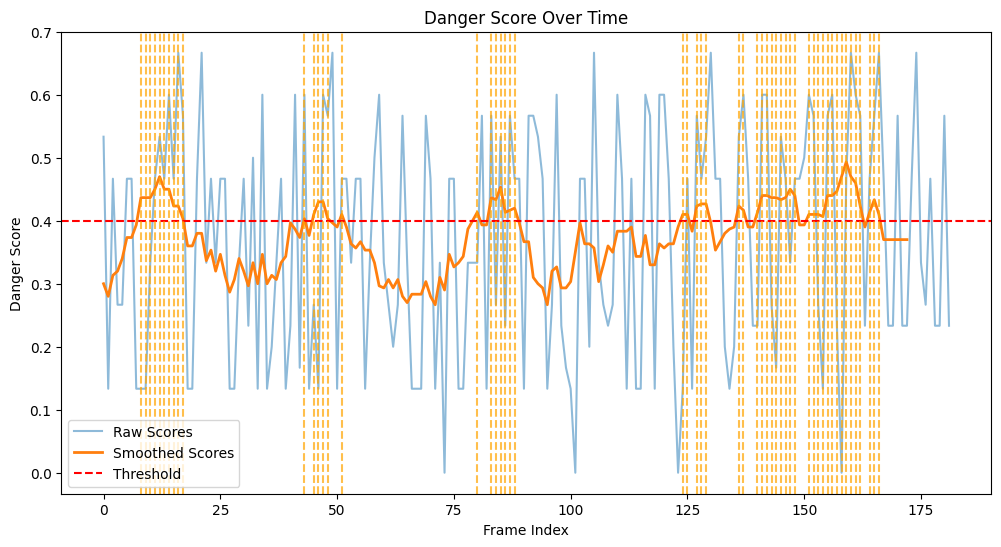

In [ ]:
plot_scores(aggregated_scores, smoothed_scores, alarm_times, threshold=0.4)